In [1]:
import pandas as pd
import numpy as np
import os
import random

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import polars as pl




## **train.parquet**

| **항목**                | **설명**                                                                 |
|-------------------------|--------------------------------------------------------------------------|
| **샘플 수**            | 10,704,179개 (약 천만 개)                                               |
| **컬럼 수**            | 119개 (Target 컬럼 `clicked` 포함)                                       |
| **컬럼 목록**           |                                                                          |
| `gender`                | 성별                                                                    |
| `age_group`             | 연령 그룹                                                               |
| `inventory_id`          | 지면 ID                                                                 |
| `day_of_week`           | 주번호                                                                  |
| `hour`                  | 시간                                                                    |
| `seq`                   | 유저 서버 로그 시퀀스                                                   |
| `l_feat_*`              | 속성 정보 피처 (27개, `l_feat_14`는 Ads set)                             |
| `feat_e_*`              | 정보영역 e 피처 (10개)                                                  |
| `feat_d_*`              | 정보영역 d 피처 (5개)                                                   |
| `feat_c_*`              | 정보영역 c 피처 (8개)                                                   |
| `feat_b_*`              | 정보영역 b 피처 (6개)                                                   |
| `feat_a_*`              | 정보영역 a 피처 (17개)                                                  |
| `history_a_*`           | 과거 인기도 피처 (6개)                                                  |
| `history_b_*`           | 과거 인기도 피처 (30개)                                                 |
| `clicked`               | 클릭 여부 (Label, Target)                                               |

## **test.parquet**

| **항목**                | **설명**                                                                 |
|-------------------------|--------------------------------------------------------------------------|
| **샘플 수**            | 1,527,298개 (약 백만개)                                                             |
| **컬럼 수**            | 118개 (`ID` 식별자 컬럼 포함)                                           |
| **컬럼 목록**           |                                                                          |
| `ID`                    | 샘플 식별자                                                             |
| `gender`                | 성별                                                                    |
| `age_group`             | 연령 그룹                                                               |
| `inventory_id`          | 지면 ID                                                                 |
| `day_of_week`           | 주번호                                                                  |
| `hour`                  | 시간                                                                    |
| `seq`                   | 유저 서버 로그 시퀀스                                                   |
| `l_feat_*`              | 속성 정보 피처 (27개, `l_feat_14`는 Ads set)                             |
| `feat_e_*`              | 정보영역 e 피처 (10개)                                                  |
| `feat_d_*`              | 정보영역 d 피처 (5개)                                                   |
| `feat_c_*`              | 정보영역 c 피처 (8개)                                                   |
| `feat_b_*`              | 정보영역 b 피처 (6개)                                                   |
| `feat_a_*`              | 정보영역 a 피처 (17개)                                                  |
| `history_a_*`           | 과거 인기도 피처 (6개)                                                  |
| `history_b_*`           | 과거 인기도 피처 (30개)                                                 |

## **sample_submission.csv**

| **항목**                | **설명**                                                                 |
|-------------------------|--------------------------------------------------------------------------|
| **컬럼 목록**           |                                                                          |
| `ID`                    | 샘플 식별자                                                             |
| `clicked`               | 광고를 클릭할 확률 (0 ~ 1)                                              |

In [2]:

all_train = pl.read_parquet("../data/train.parquet")
test = pl.read_parquet("../data/test.parquet")

print("Train shape:", all_train.shape)
print("Test shape:", test.shape)

Train shape: (10704179, 119)
Test shape: (1527298, 119)


In [3]:

all_train = pl.read_parquet("../data/processed/train_processed.parquet")
test = pl.read_parquet("../data/processed/test_processed.parquet")

print("Train shape:", all_train.shape)
print("Test shape:", test.shape)

Train shape: (10704179, 44)
Test shape: (1527298, 44)


In [5]:
all_train.head(10)

gender,age_group,inventory_id,day_of_week,hour,seq,l_feat_1,l_feat_2,l_feat_3,l_feat_4,l_feat_5,l_feat_6,l_feat_7,l_feat_8,l_feat_9,l_feat_10,l_feat_11,l_feat_12,l_feat_13,l_feat_14,l_feat_15,l_feat_16,l_feat_17,l_feat_18,l_feat_19,l_feat_20,l_feat_21,l_feat_22,l_feat_23,l_feat_24,l_feat_25,l_feat_26,l_feat_27,feat_e_1,feat_e_2,feat_e_3,feat_e_4,…,history_a_2,history_a_3,history_a_4,history_a_5,history_a_6,history_a_7,history_b_1,history_b_2,history_b_3,history_b_4,history_b_5,history_b_6,history_b_7,history_b_8,history_b_9,history_b_10,history_b_11,history_b_12,history_b_13,history_b_14,history_b_15,history_b_16,history_b_17,history_b_18,history_b_19,history_b_20,history_b_21,history_b_22,history_b_23,history_b_24,history_b_25,history_b_26,history_b_27,history_b_28,history_b_29,history_b_30,clicked
str,str,str,str,str,str,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i32
"""1.0""","""7.0""","""36""","""5""","""13""","""9,18,269,516,57,97,527,74,317,…",1.0,2.0,1.0,23.0,1.0,1.0,193.0,2.0,50.0,118.0,743.0,2877.0,2.0,1591.0,1058.0,2.0,50.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,1129.0,5.0,2.0,65.0,-4230.666504,23.863636,-0.05,…,-0.055556,0.02439,-326.857147,-0.014493,-183.285721,-13.596154,0.115821,0.138626,0.047507,0.050622,0.026479,0.001558,0.024922,0.051401,0.004673,0.021028,0.072428,0.007009,0.028816,0.05841,0.000779,0.072428,0.016355,0.011682,0.010124,0.002336,0.008567,0.070092,0.070092,0.011682,0.004673,0.087226,0.049843,0.015576,0.040498,0.051401,0
"""1.0""","""7.0""","""2""","""5""","""08""","""9,144,269,57,516,97,527,74,315…",2.0,2.0,3.0,17.0,193.0,116.0,164.0,2.0,14.0,109.0,674.0,218.0,2.0,122.0,751.0,1.0,14.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,1129.0,16.0,1.0,65.0,-1346.648193,4.545455,-0.05,…,0.0,0.0,-382.285706,0.0,-176.0,-11.442307,0.068794,0.072179,0.049471,0.052715,0.027574,0.001622,0.025952,0.053526,0.004866,0.021897,0.075423,0.007299,0.030007,0.060825,0.000811,0.075423,0.017031,0.012165,0.010543,0.002433,0.008921,0.07299,0.07299,0.012165,0.004866,0.045416,0.051904,0.01622,0.042172,0.026763,0
"""1.0""","""7.0""","""36""","""5""","""11""","""269,516,57,97,165,527,74,77,31…",1.0,2.0,1.0,7.0,675.0,85.0,227.0,2.0,362.0,212.0,1029.0,3916.0,1.0,2924.0,2304.0,2.0,362.0,3.0,2.0,2.0,2.0,2.0,1.0,1.0,1129.0,16.0,1.0,64.638885,-3195.388916,22.727272,-0.05,…,-0.111111,0.097561,-409.0,-0.014493,-224.714279,-13.942307,0.112947,0.169634,0.038753,0.041295,0.0216,0.001271,0.02033,0.04193,0.003812,0.017153,0.059083,0.005718,0.023506,0.047647,0.000635,0.059083,0.026683,0.00953,0.008259,0.001906,0.006988,0.057177,0.057177,0.00953,0.003812,0.035577,0.081318,0.012706,0.033036,0.062898,0
"""1.0""","""8.0""","""37""","""5""","""11""","""269,57,516,21,214,269,561,214,…",2.0,2.0,2.0,7.0,294.0,442.0,130.0,2.0,163.0,179.0,102.0,789.0,2.0,2169.0,439.0,1.0,163.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,1129.0,4.0,1.0,65.0,-4029.962891,3.863636,-0.05,…,-0.055556,0.02439,-274.428558,-0.014493,-127.85714,-9.846154,0.159843,0.198657,0.068082,0.072546,0.037947,0.002232,0.035715,0.073663,0.006697,0.030135,0.103797,0.010045,0.041296,0.083707,0.002232,0.103797,0.023438,0.016741,0.014509,0.003348,0.012277,0.100449,0.100449,0.016741,0.006697,0.062502,0.07143,0.022322,0.058037,0.073659,0
"""2.0""","""7.0""","""37""","""5""","""07""","""144,269,57,516,35,479,57,516,5…",2.0,2.0,3.0,24.0,497.0,435.0,171.0,2.0,193.0,131.0,690.0,110.0,1.0,2084.0,106.0,1.0,193.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,1129.0,15.0,4.0,65.0,-2106.407471,8.522727,-0.05,…,0.0,0.0,-407.571442,0.0,-199.142853,-14.019231,0.056166,0.063795,0.043725,0.046592,0.024371,0.001434,0.022938,0.047309,0.004301,0.019354,0.066662,0.006451,0.026522,0.05376,0.000717,0.066662,0.015053,0.010752,0.009318,0.00215,0.007885,0.064512,0.064512,0.010752,0.004301,0.040141,0.045875,0.014336,0.037274,0.023654,0
"""1.0""","""5.0""",

# 1. 상관관계 분석 (가장 빠름)

In [8]:
from sklearn.feature_selection import mutual_info_classif
import pandas as pd

def efficient_full_mi(df, target="clicked", batch_size=50):
    print(f"전체 데이터 MI 계산 시작: {len(df):,}행")
    
    numeric_cols = df.select(pl.col(pl.NUMERIC_DTYPES)).columns
    feature_cols = [col for col in numeric_cols if col != target]
    print(f"처리할 컬럼 수: {len(feature_cols)}")
    
    all_mi = []
    
    for i in range(0, len(feature_cols), batch_size):
        batch_cols = feature_cols[i:i+batch_size]
        
        # NaN 처리
        X_batch = df.select(batch_cols).to_pandas().fillna(0)
        y = df.select(target).to_pandas().values
        
        mi_scores = mutual_info_classif(X_batch, y, discrete_features='auto', random_state=42)
        
        for col, score in zip(batch_cols, mi_scores):
            all_mi.append({"feature": col, "mutual_info": score})
        
        print(f"진행률: {min(i+batch_size, len(feature_cols))}/{len(feature_cols)}")
    
    result_df = pd.DataFrame(all_mi)
    result_df = result_df.sort_values("mutual_info", ascending=False)
    
    return result_df

# 적용
mi_results = efficient_full_mi(all_train)
print("상위 40개 특성:")
print(mi_results.head(40))

전체 데이터 MI 계산 시작: 10,704,179행
처리할 컬럼 수: 42


/tmp/ipykernel_1390322/3042120431.py:7: DeprecationWarning: `NUMERIC_DTYPES` was deprecated in version 1.0.0. Define your own data type groups or use the `polars.selectors` module for selecting columns of a certain data type.
  numeric_cols = df.select(pl.col(pl.NUMERIC_DTYPES)).columns
/root/toss-ad-click-prediction/toss-ml-venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


: 

In [6]:
# 상관관계 분석 
import time

def efficient_full_correlation(df):
    """
    전체 데이터를 사용하되 효율적으로 처리
    """
    print(f"전체 데이터 상관관계 계산 시작: {len(df):,}행")
    
    # 숫자형 컬럼만 선택
    numeric_cols = df.select(pl.col(pl.NUMERIC_DTYPES)).columns
    target_cols = [col for col in numeric_cols if col != "clicked"]
    
    print(f"처리할 컬럼 수: {len(target_cols)}")
    
    # 한 번에 모든 상관관계 계산 (가장 효율적)
    start_time = time.time()
    
    # polars의 벡터화된 연산 활용
    corr_exprs = [pl.corr("clicked", col).alias(f"{col}_corr") 
                  for col in target_cols]
    
    # 배치 처리 - 한번에 모든 상관관계 계산
    batch_size = 50  # 50개씩 나누어 처리 (메모리 관리)
    all_correlations = []
    
    for i in range(0, len(corr_exprs), batch_size):
        batch_exprs = corr_exprs[i:i+batch_size]
        batch_result = df.select(batch_exprs)
        
        # 결과를 리스트로 변환
        for col_name in batch_result.columns:
            feature_name = col_name.replace("_corr", "")
            corr_value = batch_result.select(col_name).item()
            all_correlations.append({
                "feature": feature_name, 
                "correlation": corr_value
            })
        
        print(f"진행률: {min(i+batch_size, len(corr_exprs))}/{len(corr_exprs)}")
    
    end_time = time.time()
    print(f"완료! 소요시간: {end_time - start_time:.2f}초")
    
    # 결과 정렬
    import pandas as pd
    result_df = pd.DataFrame(all_correlations)
    result_df = result_df.sort_values("correlation", key=abs, ascending=False)
    
    return result_df

# 전체 데이터로 효율적 계산
full_correlations = efficient_full_correlation(all_train)
print("상위 40개 특성:")
print(full_correlations.head(44))


전체 데이터 상관관계 계산 시작: 10,704,179행
처리할 컬럼 수: 42


/tmp/ipykernel_1390322/4004525209.py:11: DeprecationWarning: `NUMERIC_DTYPES` was deprecated in version 1.0.0. Define your own data type groups or use the `polars.selectors` module for selecting columns of a certain data type.
  numeric_cols = df.select(pl.col(pl.NUMERIC_DTYPES)).columns


진행률: 42/42
완료! 소요시간: 0.38초
상위 40개 특성:
          feature  correlation
15    history_a_1     0.068000
16    history_a_2    -0.060412
17    history_a_3     0.059675
18    history_a_5    -0.059130
20    history_b_2     0.059034
30   history_b_30     0.057875
19    history_b_1     0.051917
1    inventory_id     0.051866
10       feat_b_4    -0.048458
24   history_b_10     0.048412
12       feat_d_3    -0.046677
14       feat_e_1    -0.045638
26   history_b_17     0.044046
25   history_b_15     0.043015
23    history_b_9     0.042772
21    history_b_3     0.042717
27   history_b_20     0.042627
28   history_b_27     0.042265
29   history_b_28     0.042062
22    history_b_5     0.042018
2      seq_length    -0.021842
34       l_feat_5     0.015024
11       feat_c_8    -0.014627
41      l_feat_15     0.011832
31       l_feat_1     0.011727
13       feat_d_4     0.009787
37       l_feat_9     0.009170
36       l_feat_7     0.008672
3       seq_first     0.008211
35       l_feat_6     0.008177
3

In [6]:
print(len(all_train.filter(pl.col('clicked') == 1)), len(all_train.filter(pl.col('clicked') == 0)))

print(len(all_train.filter(pl.col('clicked') == 0))/len(all_train.filter(pl.col('clicked') == 1)))

204179 10500000
51.42546491069111


- 클릭한 사람: 204179 
- 클릭 안한 사람: 10500000 (한 사람에 비해 50배)

In [ ]:
clicked_1 = all_train.filter(pl.col('clicked') == 1)

clicked_0 = all_train.filter(pl.col('clicked') == 0).sample(
    n=len(clicked_1) * 9,  # 클릭 한 거에 9배 정도로 -> 1:9, 총 ~200만개 정도
    seed=42
)

#train = pl.concat([clicked_1, clicked_0]).sample(
#    fraction=1.0,  # frac 대신 fraction 사용
#    seed=42
#)

#train_pd = train.to_pandas()
#train_pd = all_train.to_pandas()
#test_pd = test.to_pandas()
#train = train_pd.copy()
#test = test_pd.copy()

In [ ]:
train = all_train.copy()
test = test.copy()

print(train.shape, test.shape)

AttributeError: 'DataFrame' object has no attribute 'copy'

: 

# 결측치 확인 및 제거

In [6]:

missing = train.isnull().sum()
missing = missing[missing > 0]

grouped = missing.groupby(missing).apply(lambda x: list(x.index))

for count, cols in grouped.items():
    print(count, cols)

3272 ['gender', 'age_group', 'l_feat_2', 'l_feat_8', 'l_feat_18', 'l_feat_19', 'l_feat_20', 'l_feat_21', 'l_feat_22', 'l_feat_23', 'l_feat_24', 'feat_e_1', 'feat_e_2', 'feat_e_4', 'feat_e_5', 'feat_e_6', 'feat_e_7', 'feat_e_8', 'feat_e_9', 'feat_e_10', 'feat_d_1', 'feat_d_2', 'feat_d_3', 'feat_d_4', 'feat_d_5', 'feat_d_6', 'feat_c_1', 'feat_c_2', 'feat_c_3', 'feat_c_4', 'feat_c_5', 'feat_c_6', 'feat_c_7', 'feat_c_8', 'feat_b_1', 'feat_b_2', 'feat_b_3', 'feat_b_4', 'feat_b_5', 'feat_b_6', 'history_a_1', 'history_a_2', 'history_a_3', 'history_a_4', 'history_a_5', 'history_a_6', 'history_a_7', 'history_b_1', 'history_b_2', 'history_b_3', 'history_b_4', 'history_b_5', 'history_b_6', 'history_b_7', 'history_b_8', 'history_b_9', 'history_b_10', 'history_b_11', 'history_b_12', 'history_b_13', 'history_b_14', 'history_b_15', 'history_b_16', 'history_b_17', 'history_b_18', 'history_b_19', 'history_b_20', 'history_b_21', 'history_b_22', 'history_b_23', 'history_b_24', 'history_b_25', 'history_b_

- 3272 ['gender', 'age_group', 'l_feat_2', 'l_feat_8', 'l_feat_18', 'l_feat_19', 'l_feat_20', 'l_feat_21', 'l_feat_22', 'l_feat_23', 'l_feat_24', 'feat_e_1', 'feat_e_2', 'feat_e_4', 'feat_e_5', 'feat_e_6', 'feat_e_7', 'feat_e_8', 'feat_e_9', 'feat_e_10', 'feat_d_1', 'feat_d_2', 'feat_d_3', 'feat_d_4', 'feat_d_5', 'feat_d_6', 'feat_c_1', 'feat_c_2', 'feat_c_3', 'feat_c_4', 'feat_c_5', 'feat_c_6', 'feat_c_7', 'feat_c_8', 'feat_b_1', 'feat_b_2', 'feat_b_3', 'feat_b_4', 'feat_b_5', 'feat_b_6', 'history_a_1', 'history_a_2', 'history_a_3', 'history_a_4', 'history_a_5', 'history_a_6', 'history_a_7', 'history_b_1', 'history_b_2', 'history_b_3', 'history_b_4', 'history_b_5', 'history_b_6', 'history_b_7', 'history_b_8', 'history_b_9', 'history_b_10', 'history_b_11', 'history_b_12', 'history_b_13', 'history_b_14', 'history_b_15', 'history_b_16', 'history_b_17', 'history_b_18', 'history_b_19', 'history_b_20', 'history_b_21', 'history_b_22', 'history_b_23', 'history_b_24', 'history_b_25', 'history_b_26', 'history_b_27', 'history_b_28', 'history_b_29', 'history_b_30']
- 3600 ['feat_a_1', 'feat_a_2', 'feat_a_3', 'feat_a_4', 'feat_a_5', 'feat_a_6', 'feat_a_7', 'feat_a_8', 'feat_a_9', 'feat_a_10', 'feat_a_11', 'feat_a_12', 'feat_a_13', 'feat_a_14', 'feat_a_15', 'feat_a_16', 'feat_a_17', 'feat_a_18']
- 207305 ['feat_e_3']

In [7]:
(train['gender'].isnull() == train['age_group'].isnull()).all()

np.True_

 “gender랑 age_group은 결측 패턴이 100% 같다
 --- 
.all() 은 전부냐? 하는 확인하는 함수
```
arr = [True, True, False]
print(all(arr))     # False
```

- train['gender'].isnull() → gender가 NaN인 곳을 True/False로 표시
- train['age_group'].isnull() → age_group이 NaN인 곳을 True/False로 표시
    - 비교 → 두 개가 같으면 True, 다르면 False
    - .all() → 그 결과가 전부 True면 True 반환

In [8]:
cols = ['gender', 'age_group', 'l_feat_2','feat_e_4']
train[cols].isnull().sum(axis=1).value_counts()

0    2038518
4       3272
Name: count, dtype: int64

- 0 → 2,038,518개의 행에서는 네 컬럼(gender, age_group, l_feat_2, feat_e_4) 모두 결측치 없음.
- 3 → 3,272개의 행에서는 네 컬럼 모두 동시에 결측치(NaN).


In [9]:
train = train.dropna(subset=cols)
print(train.shape)

test = test.dropna(subset=cols)
print(test.shape)

(2038518, 119)
(1526362, 119)


train: 3272 개의 행 제거 / train: 936 행 제거

In [31]:

missing = train.isnull().sum()
missing = missing[missing > 0]

grouped = missing.groupby(missing).apply(lambda x: list(x.index))

for count, cols in grouped.items():
    print(count, cols)

328 ['feat_a_1', 'feat_a_2', 'feat_a_3', 'feat_a_4', 'feat_a_5', 'feat_a_6', 'feat_a_7', 'feat_a_8', 'feat_a_9', 'feat_a_10', 'feat_a_11', 'feat_a_12', 'feat_a_13', 'feat_a_14', 'feat_a_15', 'feat_a_16', 'feat_a_17', 'feat_a_18']
205183 ['feat_e_3']


In [32]:
cols = ['feat_a_1', 'feat_a_2', 'feat_a_3', 'feat_a_4', 'feat_a_5', 'feat_a_6', 'feat_a_7', 'feat_a_8', 'feat_a_9', 'feat_a_10', 'feat_a_11', 'feat_a_12', 'feat_a_13', 'feat_a_14', 'feat_a_15', 'feat_a_16', 'feat_a_17', 'feat_a_18']
train[cols].isnull().sum(axis=1).value_counts()

0     2038190
18        328
Name: count, dtype: int64

In [14]:
train = train[train[cols].notnull().all(axis=1)]
print(train.shape)

test = test[test[cols].notnull().all(axis=1)]
print(test.shape)

(2038190, 118)
(1526192, 118)


In [79]:
train.head(4)

,gender,age_group,inventory_id,day_of_week,hour,seq,l_feat_1,l_feat_2,l_feat_3,l_feat_4,...,history_b_22,history_b_23,history_b_24,history_b_25,history_b_26,history_b_27,history_b_28,history_b_29,history_b_30,clicked
0,1.0,7.0,29,5,18,NaN,2.0,2.0,3.0,7.0,...,0.270270,0.270270,0.045045,0.018018,0.168168,0.192192,0.060060,0.156156,0.198198,1
1,2.0,3.0,29,5,23,NaN,2.0,2.0,2.0,14.0,...,1.216215,1.216215,0.202703,0.081081,0.756756,0.864864,0.270270,0.702702,0.445946,1
2,1.0,8.0,41,5,17,NaN,2.0,2.0,2.0,19.0,...,0.037629,0.037629,0.006272,0.002509,0.023414,0.026758,0.008362,0.021741,0.068980,1
3,2.0,7.0,31,5,14,NaN,2.0,2.0,3.0,7.0,...,0.189072,0.189072,0.031512,0.012605,0.117645,0.134451,0.042016,0.109242,0.069326,1


train: 328개의 행 제거 / test: 0개의 행 제거

In [34]:

missing = train.isnull().sum()
missing = missing[missing > 0]

grouped = missing.groupby(missing).apply(lambda x: list(x.index))

for count, cols in grouped.items():
    print(count, cols)

205154 ['feat_e_3']


In [12]:
train = train.drop(columns = 'feat_e_3', axis = 1)
print(train.shape)

test = test.drop(columns = 'feat_e_3', axis = 1)
print(test.shape)

(2038518, 118)
(1526362, 118)


trian, test 모두 1열 제거

In [15]:

missing = train.isnull().sum()
missing = missing[missing > 0]

grouped = missing.groupby(missing).apply(lambda x: list(x.index))

for count, cols in grouped.items():
    print(count, cols)

# 결측치 제거 완

In [17]:
print(train.shape, test.shape)

(2038190, 118) (1526192, 118)


# 자료형 변경 및 수치형 특징 확인

In [25]:
numerical_cols = train.select_dtypes(include=[np.number]).columns.tolist()
print(len(numerical_cols), numerical_cols)

object_cols = train.select_dtypes(include='object').columns.tolist()
print(len(object_cols), object_cols)

112 ['l_feat_1', 'l_feat_2', 'l_feat_3', 'l_feat_4', 'l_feat_5', 'l_feat_6', 'l_feat_7', 'l_feat_8', 'l_feat_9', 'l_feat_10', 'l_feat_11', 'l_feat_12', 'l_feat_13', 'l_feat_14', 'l_feat_15', 'l_feat_16', 'l_feat_17', 'l_feat_18', 'l_feat_19', 'l_feat_20', 'l_feat_21', 'l_feat_22', 'l_feat_23', 'l_feat_24', 'l_feat_25', 'l_feat_26', 'l_feat_27', 'feat_e_1', 'feat_e_2', 'feat_e_4', 'feat_e_5', 'feat_e_6', 'feat_e_7', 'feat_e_8', 'feat_e_9', 'feat_e_10', 'feat_d_1', 'feat_d_2', 'feat_d_3', 'feat_d_4', 'feat_d_5', 'feat_d_6', 'feat_c_1', 'feat_c_2', 'feat_c_3', 'feat_c_4', 'feat_c_5', 'feat_c_6', 'feat_c_7', 'feat_c_8', 'feat_b_1', 'feat_b_2', 'feat_b_3', 'feat_b_4', 'feat_b_5', 'feat_b_6', 'feat_a_1', 'feat_a_2', 'feat_a_3', 'feat_a_4', 'feat_a_5', 'feat_a_6', 'feat_a_7', 'feat_a_8', 'feat_a_9', 'feat_a_10', 'feat_a_11', 'feat_a_12', 'feat_a_13', 'feat_a_14', 'feat_a_15', 'feat_a_16', 'feat_a_17', 'feat_a_18', 'history_a_1', 'history_a_2', 'history_a_3', 'history_a_4', 'history_a_5', 'his

In [27]:
for col in object_cols:
    train[col] = pd.to_numeric(train[col], errors='coerce')
    test[col] = pd.to_numeric(test[col], errors='coerce')

In [29]:
object_cols = train.select_dtypes(include='object').columns.tolist()
print(len(object_cols), object_cols)   

0 []


In [47]:
cols = train.columns.to_list()
print(cols[0:6])   # 6개 : ['gender', 'age_group', 'inventory_id', 'day_of_week', 'hour', 'seq']
print(cols[6:33])  #27개 : ['l_feat_1', 'l_feat_2', 'l_feat_3',.... 'l_feat_27']
print(cols[33:80]) #47개 : ['feat_e_1', 'feat_e_2', 'feat_e_4', ... 'feat_a_18']
print(cols[80:-1]) #37개  : ['history_a_1', 'history_a_2', 'history_a_3',...'history_b_30']
print(cols[-1])    #1개 : clicked

['gender', 'age_group', 'inventory_id', 'day_of_week', 'hour', 'seq']
['l_feat_1', 'l_feat_2', 'l_feat_3', 'l_feat_4', 'l_feat_5', 'l_feat_6', 'l_feat_7', 'l_feat_8', 'l_feat_9', 'l_feat_10', 'l_feat_11', 'l_feat_12', 'l_feat_13', 'l_feat_14', 'l_feat_15', 'l_feat_16', 'l_feat_17', 'l_feat_18', 'l_feat_19', 'l_feat_20', 'l_feat_21', 'l_feat_22', 'l_feat_23', 'l_feat_24', 'l_feat_25', 'l_feat_26', 'l_feat_27']
['feat_e_1', 'feat_e_2', 'feat_e_4', 'feat_e_5', 'feat_e_6', 'feat_e_7', 'feat_e_8', 'feat_e_9', 'feat_e_10', 'feat_d_1', 'feat_d_2', 'feat_d_3', 'feat_d_4', 'feat_d_5', 'feat_d_6', 'feat_c_1', 'feat_c_2', 'feat_c_3', 'feat_c_4', 'feat_c_5', 'feat_c_6', 'feat_c_7', 'feat_c_8', 'feat_b_1', 'feat_b_2', 'feat_b_3', 'feat_b_4', 'feat_b_5', 'feat_b_6', 'feat_a_1', 'feat_a_2', 'feat_a_3', 'feat_a_4', 'feat_a_5', 'feat_a_6', 'feat_a_7', 'feat_a_8', 'feat_a_9', 'feat_a_10', 'feat_a_11', 'feat_a_12', 'feat_a_13', 'feat_a_14', 'feat_a_15', 'feat_a_16', 'feat_a_17', 'feat_a_18']
['history_a_

In [19]:
feature_groups = {
        'user_profile': ['gender', 'age_group'],
        'context': ['inventory_id', 'day_of_week', 'hour', 'seq'],
        'ad_attributes': [col for col in train.columns if col.startswith('l_feat_')],
        'interaction_a': [col for col in train.columns if col.startswith('feat_a_')],
        'interaction_b': [col for col in train.columns if col.startswith('feat_b_')],
        'interaction_c': [col for col in train.columns if col.startswith('feat_c_')],
        'interaction_d': [col for col in train.columns if col.startswith('feat_d_')],
        'interaction_e': [col for col in train.columns if col.startswith('feat_e_')],
        'historical_a': [col for col in train.columns if col.startswith('history_a_')],
        'historical_b': [col for col in train.columns if col.startswith('history_b_')]
    }

for group, features in feature_groups.items():
    print(group, len(features))

user_profile 2
context 4
ad_attributes 27
interaction_a 18
interaction_b 6
interaction_c 8
interaction_d 6
interaction_e 9
historical_a 7
historical_b 30


In [53]:
# 성별 분석
gender_stats = train.groupby('gender').agg({
    'clicked': ['count', 'sum', 'mean','std']
}).round(4)
gender_stats.columns = ['총_샘플수', '클릭수', '클릭률', '클릭률(분산)']

print(gender_stats)

          총_샘플수     클릭수     클릭률  클릭률(분산)
gender                                  
1.0     1281880  130593  0.1019   0.3025
2.0      756310   73070  0.0966   0.2954


- 1인 성별이 2인 성별보다 기본적으로 많고, 그렇게 차이가 있나...? 싶다. 
- 각각 0.1, 0.09 의 클릭율로보아 성별에 따른 클릭수 차이는 크지 않음

In [52]:
# 연령그룹 분석
age_stats = train.groupby('age_group').agg({
    'clicked': ['count', 'sum', 'mean','std']
}).round(4)
age_stats.columns = ['총_샘플수', '클릭수', '클릭률', '클릭률(분산)']

print(f"\n📊 연령그룹 통계:")
print(age_stats.sort_values('클릭률', ascending=False))


📊 연령그룹 통계:
            총_샘플수    클릭수     클릭률  클릭률(분산)
age_group                                
1.0          6673   1930  0.2892   0.4534
8.0        512844  60614  0.1182   0.3228
2.0         69664   8026  0.1152   0.3193
3.0         91581   9245  0.1009   0.3013
4.0        105476  10353  0.0982   0.2975
7.0        701296  64800  0.0924   0.2896
5.0        112430  10276  0.0914   0.2882
6.0        438226  38419  0.0877   0.2828


- 1번 그룹이 클릭율이 나머지 그룹의 3배 높은 클릭률! 매우 높은것으로 보아 20대?30 대가 아닐까?? 싶음 
- 1, 8, 2, 3, 4, 7, 5, 6 순으로 클릭율이 낮아짐
- 6번 그룹이 클랙율이 가장 낮은것으로 보아 연령층이 높은 곳이 아닐까?? 싶음

--- 
1. 🥇 age_group 1.0: 28.92% (특이케이스)
2. 🥈 age_group 8.0: 11.82% (51만명 - 메인타겟) 
3. 🥉 age_group 2.0: 11.52% (7만명)
4. 4위 age_group 3.0: 10.09%
5. 5위 age_group 4.0: 9.82%
...최하위 age_group 6.0: 8.77%
--- 
피처 엔지니어링: 
```
# 연령 기반 새 피처들
df['age_tier'] = df['age_group'].map({
    1.0: 'PREMIUM',   # 28.9% CTR
    8.0: 'HIGH',      # 11.8% CTR  
    2.0: 'HIGH',      # 11.5% CTR
    3.0: 'MID',       # 10.1% CTR
    4.0: 'MID',       # 9.8% CTR
    7.0: 'LOW',       # 9.2% CTR
    5.0: 'LOW',       # 9.1% CTR
    6.0: 'LOW'        # 8.8% CTR
})
```
아니면 ```df[is_age_1] or not``` 으로 시도해볼 수 있을 듯


--- 

https://dacon.io/competitions/official/236575/talkboard/415131?page=1&dtype=recent


In [55]:
gender_age_stats = train.groupby(['gender', 'age_group']).agg({
    'clicked': ['count', 'sum', 'mean', 'std']
}).round(4)

# 컬럼 이름 바꾸기
gender_age_stats.columns = ['총_샘플수', '클릭수', '클릭률', '클릭률(분산)']

print(gender_age_stats.sort_values('클릭률', ascending=False))


                   총_샘플수    클릭수     클릭률  클릭률(분산)
gender age_group                                
1.0    1.0          4050   1217  0.3005   0.4585
2.0    1.0          2623    713  0.2718   0.4450
       2.0         29667   3774  0.1272   0.3332
1.0    8.0        346326  41586  0.1201   0.3251
2.0    8.0        166518  19028  0.1143   0.3181
       3.0         39903   4325  0.1084   0.3109
1.0    2.0         39997   4252  0.1063   0.3082
2.0    4.0         44325   4567  0.1030   0.3040
1.0    7.0        454938  43633  0.0959   0.2945
       3.0         51678   4920  0.0952   0.2935
       4.0         61151   5786  0.0946   0.2927
       5.0         64533   5899  0.0914   0.2882
2.0    5.0         47897   4377  0.0914   0.2882
1.0    6.0        259207  23300  0.0899   0.2860
2.0    7.0        246358  21167  0.0859   0.2802
       6.0        179019  15119  0.0845   0.2781



### 🔥 최고 성과: sex 1.0 + age_group 1.0 = 30.05% CTR
### 🔥 2위 성과: sex 2.0 + age_group 1.0 = 27.18% CTR
#### age_group 1.0은 성별 무관하게 "골든 세그먼트"

💦 성별 2 이고 나이그룹 6일때 가장 클릭율이 낮음

- 나이그룹 1의 경우 성별이 1일때 2보다 살짝 더 높음  
- 나이그룹 2의 경우 성별이 2일때 훨씬 클릭율이 높음 (0.3332 , 0.3082)
- 나이그룹 3의 경우 성별이 2일때 더 높음 (0.3109, 0.2935)
- 나이그룹 4의 경우, 성별이 2일때 더 높음 (0.3040, 0.2927)
... 
- 나머지는 다 비슷 비슷

--- 
## 개인화 전략 써볼 수 있음
```
def get_personalized_ctr_boost(gender, age_group):
    """성별×연령 조합별 CTR 부스트 계수"""
    
    boost_matrix = {
        (1.0, 1.0): 3.0,  # sex1×age1 → 3배 부스트
        (2.0, 1.0): 2.7,  # sex2×age1 → 2.7배 부스트  
        (2.0, 2.0): 1.3,  # sex2×age2 → 1.3배 부스트
        (1.0, 8.0): 1.2,  # sex1×age8 → 1.2배 부스트
        # ... 기본값 1.0
    }
    
    return boost_matrix.get((gender, age_group), 1.0)

```

- 🎯 과적합 위험: 작은 세그먼트 과신 금지
- 🎯 콜드스타트: 신규 성별×연령 조합 대응방안 필요
- 🎯 정규화: 극단적 CTR 값들 스무딩 고려

In [63]:
train['inventory_id'].value_counts(ascending=False)

inventory_id
2     478139
36    284788
37    278844
42    195325
29    194831
46    154650
88    138150
43     84863
31     84119
11     59184
41     48490
91     19780
39      6675
19      4857
8       3847
95       939
92       511
21       198
Name: count, dtype: int64

지면의 경우, 2번 지면의 갯수가 가장 많았고 그 뒤로 36번 37번 42번...


## 🎯 "누구에게 어떤 지면에서 광고를 보여줄까?" 를 아래의 지표에서 볼 수 있음

                      총_샘플수    클릭수     클릭률  클릭률(분산)
gender inventory_id                                
1.0    2             314342  15371  0.0489   0.2157
       8               2766    107  0.0387   0.1929
       11             36678   2414  0.0658   0.2480
       19              2782    235  0.0845   0.2781
       21               104     28  0.2692   0.4457
       29            117320  13158  0.1122   0.3156
       31             36456   4567  0.1253   0.3310
       36            185300  15192  0.0820   0.2743
       37            188086  28595  0.1520   0.3591
       39              3196    294  0.0920   0.2891
       41             32451   6445  0.1986   0.3990
       42            129792  16491  0.1271   0.3330
       43             56327   4741  0.0842   0.2776
       46             99821   8723  0.0874   0.2824
       88             64821  12583  0.1941   0.3955
       91             10868   1530  0.1408   0.3478
       92               269     66  0.2454   0.4311
       95   

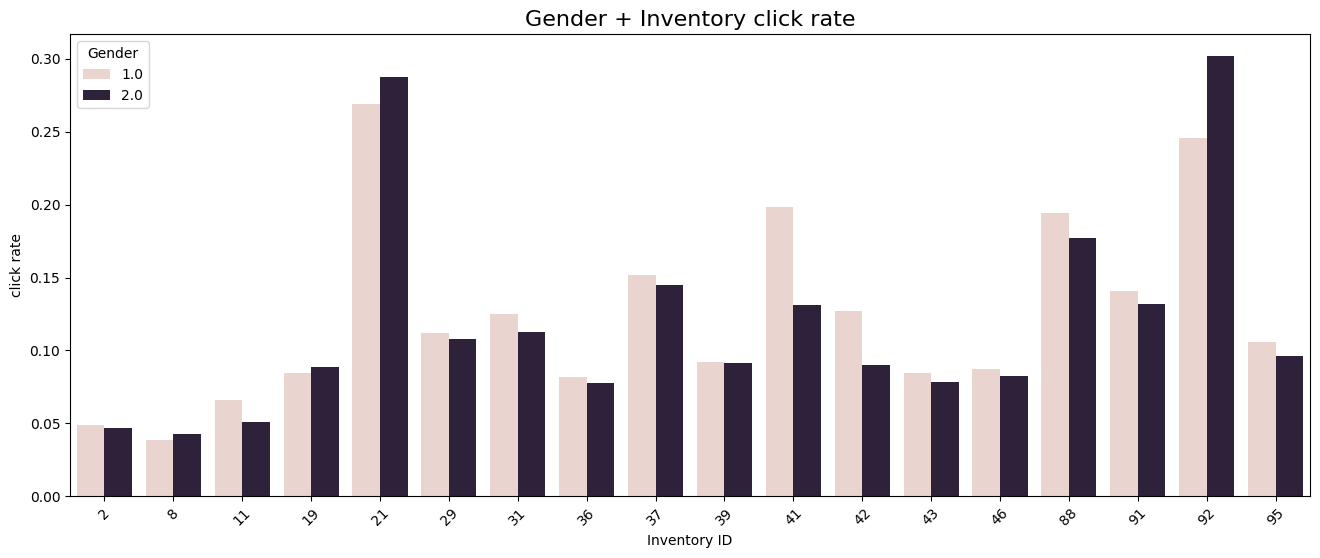

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

gender_age_stats = train.groupby(['gender', 'inventory_id']).agg({
    'clicked': ['count', 'sum', 'mean', 'std']
}).round(4)

gender_age_stats.columns = ['총_샘플수', '클릭수', '클릭률', '클릭률(분산)']

print(gender_age_stats)

# Reset index → gender와 inventory_id를 컬럼으로
gender_inv_stats = gender_age_stats.reset_index()

plt.figure(figsize=(16,6))
sns.barplot(
    data=gender_inv_stats,
    x='inventory_id',
    y='클릭률',
    hue='gender'
)
plt.title('Gender + Inventory click rate', fontsize=16)
plt.ylabel('click rate')
plt.xlabel('Inventory ID')
plt.xticks(rotation=45)
plt.legend(title='Gender')
plt.show()

- Inventory id 21, 92번의 지면 경우 클릭율이 높았다.
- 다들 또이 또이 한 가운데, 41번의 경우 성별 1의 클릭율이 높고, 92의 경우 성별 2의 클릭율이 유독 높았다

                        총_샘플수   클릭수     클릭률  클릭률(분산)
age_group inventory_id                              
1.0       2               826   217  0.2627   0.4404
          8                 1     0  0.0000      NaN
          11              166    41  0.2470   0.4326
          19               71    22  0.3099   0.4657
          21                3     3  1.0000   0.0000
...                       ...   ...     ...      ...
8.0       46            45448  4487  0.0987   0.2983
          88            12894  3481  0.2700   0.4440
          91             2140   525  0.2453   0.4304
          92               94    28  0.2979   0.4598
          95               99    14  0.1414   0.3502

[144 rows x 4 columns]


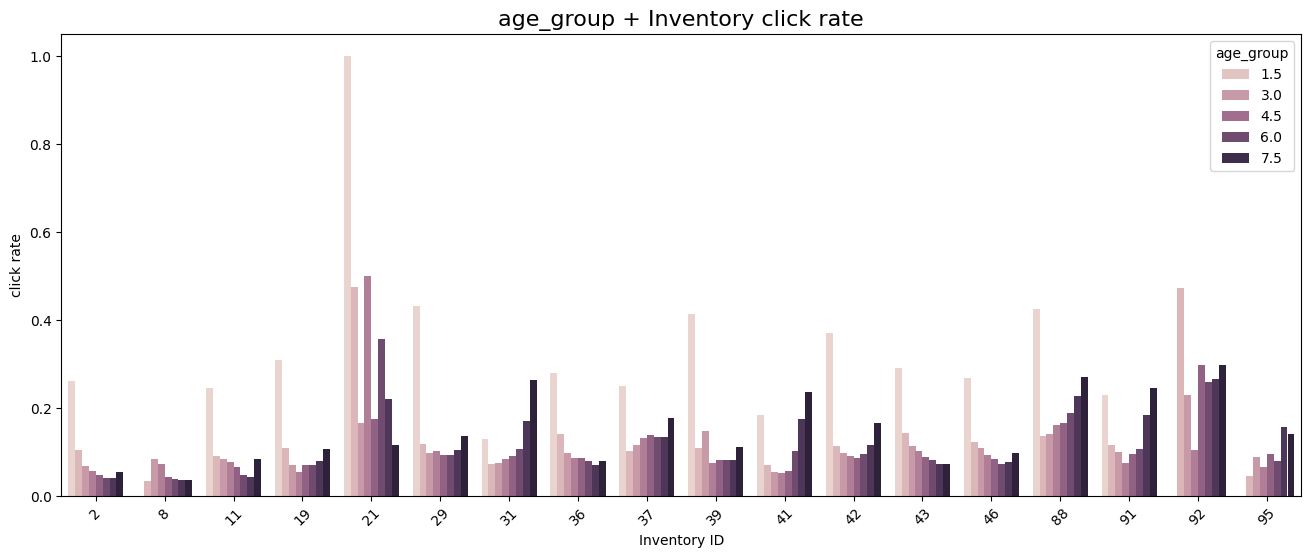

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

gender_age_stats = train.groupby(['age_group', 'inventory_id']).agg({
    'clicked': ['count', 'sum', 'mean', 'std']
}).round(4)

# 컬럼 이름 바꾸기
gender_age_stats.columns = ['총_샘플수', '클릭수', '클릭률', '클릭률(분산)']

print(gender_age_stats)

# Reset index → gender와 inventory_id를 컬럼으로
gender_inv_stats = gender_age_stats.reset_index()

plt.figure(figsize=(16,6))
sns.barplot(
    data=gender_inv_stats,
    x='inventory_id',
    y='클릭률',
    hue='age_group'
)
plt.title('age_group + Inventory click rate', fontsize=16)
plt.ylabel('click rate')
plt.xlabel('Inventory ID')
plt.xticks(rotation=45)
plt.legend(title='age_group')
plt.show()





### 🔥 age_group 1.5 × inventory_id 21 = 거의 100% CTR!

### 📱 각 지면의 타겟 연령이 극명하게 갈림:

- 전반적으로 나이그룹 1.5가 클릭율이 높은 편인데, 8번이랑 95번의 지면에서는 낮았다. 
- 95번, 31번 41번의 지면에서는 특히 나이그룹 6~7.5가 매우 높은 편

### 🚨 inventory_id 21의 100% CTR:
- 샘플 수가 매우 적을 가능성 높음
- 검증 데이터에서 급격한 성능 하락 위험
- 최소 샘플 수 임계값 설정 필요

In [76]:
# 조합별 샘플 수 확인 필수
combo_stats = train.groupby(['age_group', 'inventory_id']).agg({
    'clicked': ['count', 'mean', 'std']
})

# 신뢰할 수 없는 조합 필터링
reliable_combos = combo_stats[combo_stats[('clicked', 'count')] >= 100]
print(f"신뢰할 수 있는 조합: {len(reliable_combos)}개")

신뢰할 수 있는 조합: 120개


# 시간 패턴 분석

In [78]:
train['seq']

0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
           ..
2041785   NaN
2041786   NaN
2041787   NaN
2041788   NaN
2041789   NaN
Name: seq, Length: 2038190, dtype: float64